# Measuring Momentum

In this lecture we will talk about different ways to measure momentum.

In [4]:
from statsmodels import regression
import statsmodels.api as sm
import scipy.stats as stats
import scipy.spatial.distance as distance
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import auquanToolbox.dataloader as dl

## Moving Average Crossover

A very common way to obtain a momentum signal is to look for moving average crossovers. This means computing two moving averages of different lengths, and waiting for one to cross the other. The direction of the cross will indicate the direction of the momentum.

We'll demonstrate this on some real asset data.

Reading AAPL
Reading AIG
Reading C
Reading T
Reading PG
Reading JNJ
Reading EOG
Reading MET
Reading DOW
Reading AMGN


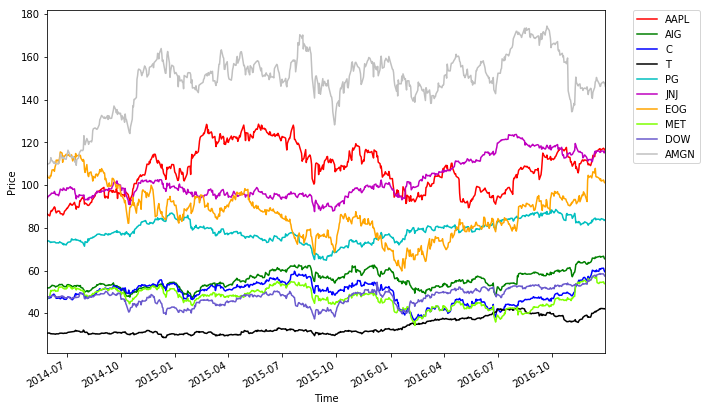

In [16]:
# Fetch prices data for 10 stocks from different sectors and plot prices
start = '2014-06-01'
end = '2016-12-31'
assets = ['AAPL', 'AIG', 'C', 'T', 'PG', 'JNJ', 'EOG', 'MET', 'DOW', 'AMGN']
data = dl.load_data_nologs('nasdaq', assets, start, end)
prices = data['ADJ CLOSE']

prices.plot(figsize=(10,7), color=['r', 'g', 'b', 'k', 'c', 'm', 'orange',
                                  'chartreuse', 'slateblue', 'silver'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Price')
plt.xlabel('Time')
plt.show()

Nowlet's pick a stock and calculate a 30 day moving average and a 200 day moving average.

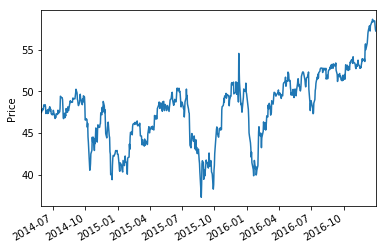

In [17]:
asset = prices.iloc[:, 8]
asset.plot()
plt.ylabel('Price')
plt.show()

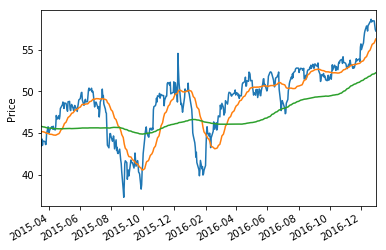

In [63]:
short_mavg = asset.rolling(window=30, center=False).mean()
long_mavg = asset.rolling(window=200, center=False).mean()

asset[200:].plot()
short_mavg[200:].plot()
long_mavg[200:].plot()
plt.ylabel('Price')
plt.show()

We can see here that there are five crossing points once both averages are fully populated. The first seems to be indicative of a following upturn, second of a downturn and so on.


### Choosing Moving Average Lengths

#### WARNING: Overfitting

The choice of lengths will strongly affect the signal that you receive from your moving average crossover strategy. There may be better windows, and attempts to find them can be made with robust optimization techniques. However, it is incredibly easy to overfit your moving window lengths. For an exmaple of this see the Dangers of Overfitting.



## Moving Average Crossover Ribbons

Another approach is to draw many moving averages at a time, and attempt to extract statistics from the shape of the 'ribbon' rather than any two moving averages. Let's see an example of this on the same asset.

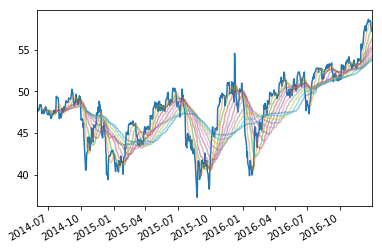

In [65]:
asset.plot(alpha = 1)

rolling_means = {}

for i in np.linspace(10, 100, 10):
    X = asset.rolling(window=int(i),center=False).mean()
    rolling_means[i] = X
    X.plot(alpha = 0.45)
    
rolling_means = pd.DataFrame(rolling_means).dropna()
plt.show()

### Information About Ribbon Shape

Here are a few quantitative measures of ribbon shape. This will in turn give us a trading signal.

#### Distance Metric

We can use a distance metric to see how far away from some given ranking our ribbon is. Here we check against a 1-10 ranking. For more ideas on distance metrics, check out [this slide deck](http://theory.stanford.edu/~sergei/slides/www10-metrics.pdf).

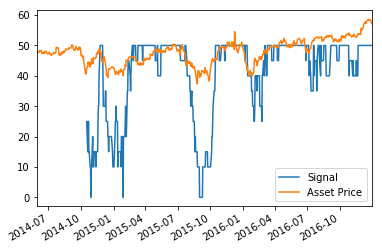

In [67]:
scores = pd.Series(index=asset.index)
for date in rolling_means.index:
    mavg_values = rolling_means.loc[date]
    ranking = stats.rankdata(mavg_values.values)
    d = distance.hamming(ranking, range(1, 11))
    scores[date] = d
    
# Normalize the  score
(50 * scores).plot();
asset.plot()
plt.legend(['Signal', 'Asset Price'])
plt.show()

We can also use a correlation metric.

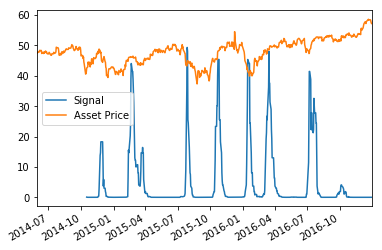

In [68]:
scores = pd.Series(index=asset.index)
for date in rolling_means.index:
    mavg_values = rolling_means.loc[date]
    ranking = stats.rankdata(mavg_values.values)
    _, d = stats.spearmanr(ranking, range(1, 11))
    scores[date] = d

# Normalize the  score
(50 * scores).plot();
asset.plot()
plt.legend(['Signal', 'Asset Price'])
plt.show()

#### Measuring Thickness

We can also just take the range of values at any given time to monitor the thickness of the ribbon.

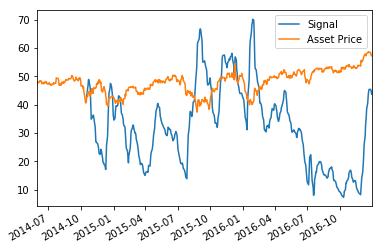

In [69]:
scores = pd.Series(index=asset.index)
for date in rolling_means.index:
    mavg_values = rolling_means.loc[date]
    d = np.max(mavg_values) - np.min(mavg_values)
    scores[date] = d
    
# Normalize the  score
(10 * scores).plot();
asset.plot()
plt.legend(['Signal', 'Asset Price'])
plt.show()

## Measures of Momentum From Physics

Here we present some measures of momentum taken from physics. The paper describing these measures can be found here http://arxiv.org/pdf/1208.2775.pdf. The authors define 4 different measures, called $p^{(1)}$, $p^{(0)}$, $p^{(2)}$, and $p^{(3)}$.

Their approach is based in physics, where the momentum is defined as $p = mv$, the product of the mass and the velocity. First, they define $x(t)$ to be the log of the price of the security. Conveniently, the return on the security is then the derivative of $x(t)$, which is called the velocity $v(t)$. Then they suggest a number of different definitions of mass $m(t)$; in the examples below, we'll use the inverse of standard deviation and turnover rate as mass. This works with our analogy because the more volatile or the less liquid an asset (the smaller its mass), the easier it is to move its price (i.e. change its position). The different momenta are then defined (for a lookback window $k$) as:
$$p^{(0)}(t) = \sum_{i=0}^{k-1} v(t-i)$$
$$p^{(1)}(t) = \sum_{i=0}^{k-1} m(t-i) v(t-i)$$
$$p^{(2)}(t) = \frac{\sum_{i=0}^{k-1} m(t-i) v(t-i)}{\sum_{i=0}^{k-1} m(t-i)}$$
$$p^{(3)}(t) = \frac{\mu(v(t-k+1),\ldots, v(t))}{\sigma(v(t-k+1),\ldots, v(t))} $$

First, let's just implement the different momentum definitions, and plot the rolling momenta for one stock.

In [46]:
k = 30
start = '2014-01-01'
end = '2015-01-01'

x = np.log(asset)
v = x.diff()
m =  data['VOLUME'].iloc[:,8]

p0 = v.rolling(window=k, center=False).sum()
p1 = m*v.rolling(window=k, center=False).sum()
p2 = p1/m.rolling(window=k, center=False).sum()
p3 = v.rolling(window=k, center=False).mean()/v.rolling(window=k, center=False).std()

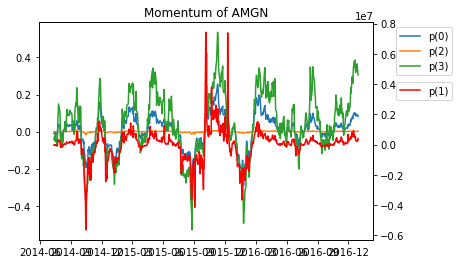

In [60]:
f, ax1 = plt.subplots()
ax1.plot(p0)
ax2 = ax1.twinx()
ax2.plot(p1,'r')
ax1.plot(p2)
ax1.plot(p3)
ax1.set_title('Momentum of AMGN')
ax1.legend(['p(0)', 'p(2)', 'p(3)'], bbox_to_anchor=(1.25, 1))
ax2.legend(['p(1)'], bbox_to_anchor=(1.25, .75))

plt.show()

### Going forward

* What are good lookback and holding period lengths? We picked 30 days as a reasonable default but others might make more sense (or even different lengths for the different momentum definitions). Be careful not to overfit here!
* Try different definitions of mass. The paper suggests turnover rate and daily transaction value (and volatility is only used for $p^{(3)}$).